# Part 2: SQLAlchemy Practice on a Business Database:  

---

By Jean-Yves Tran | jy.tran@[datascience-jy.com](https://datascience-jy.com) | [LinkedIn](https://www.linkedin.com/in/jytran-datascience/)  
IBM Certified Data Analyst 

---

The interactive links in this notebook are not working due to GitHub limitations. View this notebook with the interactive links working [here](https://nbviewer.org/github/jendives2000/Data_ML_Practice_2025/blob/main/1-3-SQL/practice/dvd_rental/PostgreSQL_SQLAlchemy_Biz-Database_dvdrental_2.ipynb#cte-winfunc).

---

Continuing on the first exploration and analysis ([click here](https://github.com/jendives2000/Data_ML_Practice_2025/blob/main/1-3-SQL/practice/dvd_rental/PostGreSQL_SQLALchemy_Business_Database_dvdrental_1.ipynb)) I am  **revisiting queries** that usually give trouble to users. These are often named **"Non-Trivial" SQL queries**, underlining the fact that they are above simple and easy:  

- Using Common Table Expression - CTE - to quickly reuse complex queries
- Filtering with subqueries and NOT with multiple where clauses
- or by JOINing a table to itself via multiple attributes with just one unique JOIN ([click here](#self-join-way))
- using a row_number() [window function](#cte-winfunc) instead of [multiple CTE](#mult-cte)

**POWER OF PYTHON:**  
I show examples of how SQLAlchemy pythonic Core approach can be leveraged to more efficiently produce queries, adding readability too.

**BASIC VISUALIZATIONS:**  
I also translated an output to a pandas dataframe that I then use to visualize the data ([here](#viz_1)) via a scatter plot and 2 box plots. I then give [observations](#obs_1). 

**REFACTORING AND FUNCTIONS:**  
For most of the SQL execution I am using a function I declared in the python file ([shared_code.py](https://github.com/jendives2000/Data_ML_Practice_2025/blob/43ed515361fb761e4bb20b73c318a9ddb1266d9e/1-3-SQL/practice/dvd_rental/shared_code.py)), following python best practices. Find it in the same folder of this notebook.  
In that same file I declared functions that I were refactored whenever it was possible and necessary. 


---


### Imports: 

In [1]:
from sqlalchemy import create_engine, cast, alias, select, and_, extract, union, literal, desc, nullsfirst, func, Time, Table, MetaData, Date
from datetime import date
from dotenv import load_dotenv
import os
from pathlib import Path
from shared_code import execute_stmt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [2]:
# Get the current working directory
current_dir = os.getcwd()


---


### .env file:  

Securing PostGreSQL credentials.

In [3]:
# Get the current working directory
current_dir = os.getcwd()

# Construct the path to the .env file
env_path = Path(current_dir).parents[2] / ".env"
print(f".env file exists: {env_path.exists()}")

# Load environment variables from the .env file
load_dotenv(dotenv_path=env_path)

.env file exists: True


True


---


### Setup of the Connection:

Connecting to the PostGreSQL database dvdrental using SQLAlchemy Core approach. 

In [4]:
# Define the PostgreSQL database URL from environment variables
DATABASE_URL = os.getenv("DATABASE_URL")

# Create the SQLAlchemy engine
engine = create_engine(DATABASE_URL)

# Create a MetaData instance
metadata_obj = MetaData()

<a id="er-diagram"></a>
## ER Diagram of the dvdrental database: 
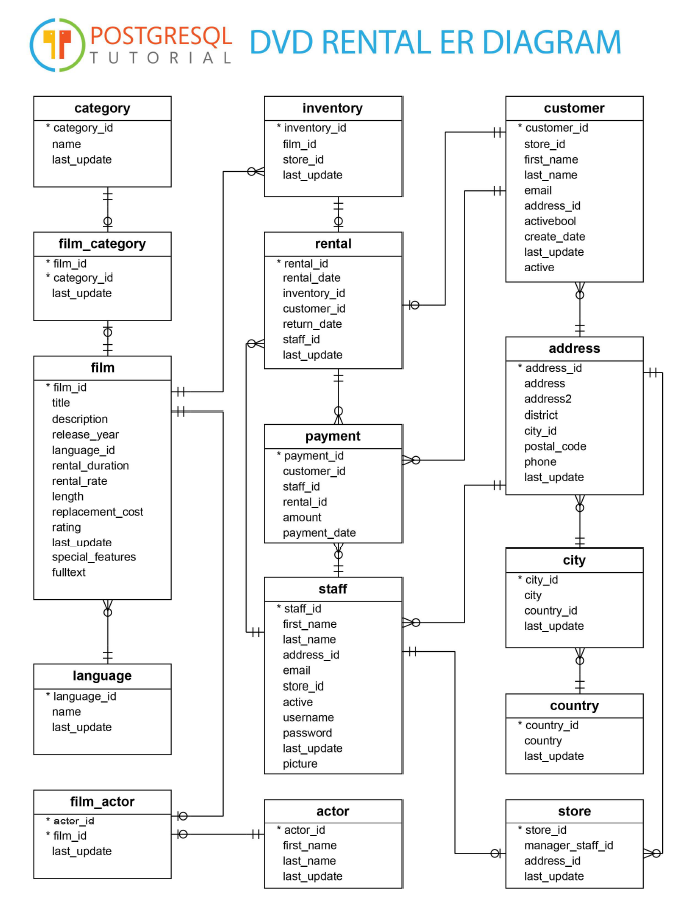


---


#### Tables Reflection:

Now from the database I need to reflect a copy of the tables I need.  It is essentially an in-memory copy of the the database at the state it is now. 

In [5]:
# Reflecting the film table: 
f = Table('film', metadata_obj, autoload_with=engine)

# Reflecting the inventory table: 
i = Table('inventory', metadata_obj, autoload_with=engine)

# Reflecting the payment table: 
p = Table('payment', metadata_obj, autoload_with=engine)

# Reflecting the rental table: 
r = Table('rental', metadata_obj, autoload_with=engine)


---


## Subqueries: 

Very useful for **filtering in queries without the need to use multiple where clauses**.  

I start by checking the whole film table just to remind myself about its columns. I need to see the **replacement_cost column**. 

### Replacement cost of films:

In [6]:
frc = f.c.replacement_cost

stmt = select(frc).limit(10)

execute_stmt(stmt, engine)


Total rows selected: 1000
Limit of 10 applied. Rows displayed: 10

Raw SQL query:
SELECT film.replacement_cost 
FROM film 
 LIMIT %(param_1)s

replacement_cost
14.99
19.99
15.99
12.99
20.99
12.99
18.99
26.99
22.99
17.99


#### Refactoring aliasing and assigning column:  

Aliasing is necessary to any subquery, especially if it is for a self join. I will be using it again, so I want to turn it into a function:

In [7]:
def alias_and_column(table, alias_name, column_name):
    """
    Create an alias for a table and return the alias along with a specific column.
    # Usage example
    f2, f2rc = alias_and_column(film, "f2", "replacement_cost")

    Parameters:
    - table: The original SQLAlchemy table object.
    - alias_name: The name of the alias for the table.
    - column_name: The name of the column to extract from the alias table.

    Returns:
    - alias_table: The alias of the original table.
    - alias_table_col: The column object from the alias table.
    """
    alias_table = table.alias(alias_name)
    alias_table_col = getattr(alias_table.c, column_name)
    return alias_table, alias_table_col

What about the average of the whole column (film replacement cost)?


---


### Average of replacement cost:
<a id="avg-frc"></a>

In [8]:
stmt_avg_rc = select(
    func.avg(frc).label("average_replacement_cost")
)
execute_stmt(stmt_avg_rc, engine)


Total rows selected: 1

Raw SQL query:
SELECT avg(film.replacement_cost) AS average_replacement_cost 
FROM film

average_replacement_cost
19.9840000000000000



---


### Improve readability:

I was requested to add readability to that replacement cost in the film table. For that I want to add columns with the value "above" when the rc is above average, and the value below too. 

#### Hard Coding ain't it:

So here is a mistake we usually do. Hard coding the filtering in a where clause:

In [9]:
stmt = select(
    frc).where(
        frc > 19.984  # hard coded value
    ).limit(25)
execute_stmt(stmt, engine)


Total rows selected: 536
Limit of 25 applied. Rows displayed: 25

Raw SQL query:
SELECT film.replacement_cost 
FROM film 
WHERE film.replacement_cost > %(replacement_cost_1)s 
 LIMIT %(param_1)s

replacement_cost
19.99
20.99
26.99
22.99
28.99
21.99
24.99
22.99
19.99
21.99
23.99
23.99
27.99
20.99
23.99
19.99
27.99
29.99
24.99
28.99
25.99
22.99
28.99
21.99
23.99


#### Useful Python object in SQLAlchemy:

Now, there are different angles that I can take to avoid hard coding the avg of frc. 

1. **Build my subquery**  
I could build a relatively complex code by aliasing the film table (for self join) and then filtering it in my main statement with a where clause. 

2. Or I could just **reuse the [SQL statement](#avg-frc) `stmt_avg_rc`** in which I already selected the AVG of frc. Which is the best approach here. For that I first need to turn it into a subquery using `.scalar_subquery()`.

In [48]:
stmt_avg_rc = select(func.avg(frc)).scalar_subquery()  # Convert to a scalar subquery

# ==== Angle 2. ====
# Reuse of `stmt_avg_rc`:
stmt = select(
    frc).where(
        frc > stmt_avg_rc
    ).limit(25)
    
execute_stmt(stmt, engine)


Total rows selected: 536
Limit of 25 applied. Rows displayed: 25

Raw SQL query:
SELECT film.replacement_cost 
FROM film 
WHERE film.replacement_cost > (SELECT avg(film.replacement_cost) AS avg_1 
FROM film) 
 LIMIT %(param_1)s

replacement_cost
19.99
20.99
26.99
22.99
28.99
21.99
24.99
22.99
19.99
21.99
23.99
23.99
27.99
20.99
23.99
19.99
27.99
29.99
24.99
28.99
25.99
22.99
28.99
21.99
23.99


This angle 1 is essentially just a repeat of the statement I reused in the code above.

In [49]:
# ==== Angle 1. ====
# aliasing of table film :
f2 = f.alias("f2")
f2rc = f2.c.replacement_cost

# subquery of the avg frc from f2:
avg_f2rc = (
    select(func.avg(
        f2rc
    ))
    .scalar_subquery()
)

stmt = select(
    frc).where(
    frc > avg_f2rc
).limit(25)
    
execute_stmt(stmt, engine)


Total rows selected: 536
Limit of 25 applied. Rows displayed: 25

Raw SQL query:
SELECT film.replacement_cost 
FROM film 
WHERE film.replacement_cost > (SELECT avg(f2.replacement_cost) AS avg_1 
FROM film AS f2) 
 LIMIT %(param_1)s

replacement_cost
19.99
20.99
26.99
22.99
28.99
21.99
24.99
22.99
19.99
21.99
23.99
23.99
27.99
20.99
23.99
19.99
27.99
29.99
24.99
28.99
25.99
22.99
28.99
21.99
23.99


I got the same output from both approaches.  
Building a query is **not always necessary**, particularly if the statement is originally simple. 

#### Refactoring the subquery assigning:

Nevertheless, for complex queries building elaborate subqueries is necessary.  
It is best to turn that into a function that I can call anytime.  

This specific function here is to **get a subquery of an aggregate**, which uses an SQL function in it parameters and a column on which it will aggregate. 

In [50]:
# Refactoring subquery function:
def subquery(Func, aliasCol):
    """For self-joins: Use an SQLAlchemy function and a column from an aliased table to get the corresponding subquery. So prior to that you need an alias.

    Args:
        Func (SQLAlchemy function): the function to use for the aggregate
        aliasCol (variable of a column attribute from an aliased table): i.e.: f2rc with f2rc = film_alias.c.replacement_cost

    Returns:
        subquery: the select subquery to use in a main select statement
    """
    return (
        select(Func(aliasCol))
        .scalar_subquery()
    )

#### Adding the column grouping:  

As I said, to add readability on this replacement_cost in the whole film table, I want to add a column grouping where values will indicate if it is 'above' or 'below' the replacement cost. 

In [51]:
# ==== Angle 1. ====
stmt = select(
    frc,
    # adding a new value named...
    literal(
        "above"  # ... this string
        ).label(
            "grouping"  # ... into a new column named this...
            )
).where(
        # ... selecting only above avg values
        frc > stmt_avg_rc
    ).limit(10)

execute_stmt(stmt, engine)


Total rows selected: 536
Limit of 10 applied. Rows displayed: 10

Raw SQL query:
SELECT film.replacement_cost, %(param_1)s AS grouping 
FROM film 
WHERE film.replacement_cost > (SELECT avg(film.replacement_cost) AS avg_1 
FROM film) 
 LIMIT %(param_2)s

replacement_cost | grouping
19.99 | above
20.99 | above
26.99 | above
22.99 | above
28.99 | above
21.99 | above
24.99 | above
22.99 | above
19.99 | above
21.99 | above


Double-checking it by selecting the whole film table.  
The grouping column is at the far right. 

**NOTE:**
Noticed how the output shows 536 rows selected but returned only 10? That was from the execute function. This way the output is not annoyingly long while still being accurate and functional. Using a .limit(10) would have limited the select further down the line.  

In [52]:
stmt_rc_above = select(
    *f.c,
    literal(
        "above"
        ).label(
            "grouping"
            )
).where(
        frc > stmt_avg_rc
    )#.limit(10)

execute_stmt(stmt_rc_above, engine, 10)


Total rows selected: 536

Raw SQL query:
SELECT film.film_id, film.title, film.description, film.release_year, film.language_id, film.rental_duration, film.rental_rate, film.length, film.replacement_cost, film.rating, film.last_update, film.special_features, film.fulltext, %(param_1)s AS grouping 
FROM film 
WHERE film.replacement_cost > (SELECT avg(film.replacement_cost) AS avg_1 
FROM film)

film_id | title | description | release_year | language_id | rental_duration | rental_rate | length | replacement_cost | rating | last_update | special_features | fulltext | grouping
384 | Grosse Wonderful | A Epic Drama of a Cat And a Explorer who must Redeem a Moose in Australia | 2006 | 1 | 5 | 4.99 | 49 | 19.99 | R | 2013-05-26 | ['Behind the Scenes'] | 'australia':18 'cat':8 'drama':5 'epic':4 'explor':11 'gross':1 'moos':16 'must':13 'redeem':14 'wonder':2 | above
1 | Academy Dinosaur | A Epic Drama of a Feminist And a Mad Scientist who must Battle a Teacher in The Canadian Rockies | 2006 

#### Adding values below or equal to avg:

Now I need to add the value `below_orEq`. In the code below I do that and also add the select statement from the previous code `stmt_rc_above`. The union clause is perfect for that:  

In [53]:
stmt_above_beloweq = union(
    # previous code
    stmt_rc_above,
    
    # adding...
    select(
    *f.c,
    literal(
        "below_orEq"  # this value to...
        ).label(
            "grouping"  # ... to this column...
            )
    ).where(
            # ... selecting only below or equal to avg values
            frc <= stmt_avg_rc
        )#.limit(10)
)

execute_stmt(stmt_above_beloweq, engine, 10)


Total rows selected: 1000

Raw SQL query:
SELECT film.film_id, film.title, film.description, film.release_year, film.language_id, film.rental_duration, film.rental_rate, film.length, film.replacement_cost, film.rating, film.last_update, film.special_features, film.fulltext, %(param_1)s AS grouping 
FROM film 
WHERE film.replacement_cost > (SELECT avg(film.replacement_cost) AS avg_1 
FROM film) UNION SELECT film.film_id, film.title, film.description, film.release_year, film.language_id, film.rental_duration, film.rental_rate, film.length, film.replacement_cost, film.rating, film.last_update, film.special_features, film.fulltext, %(param_2)s AS grouping 
FROM film 
WHERE film.replacement_cost <= (SELECT avg(film.replacement_cost) AS avg_1 
FROM film)

film_id | title | description | release_year | language_id | rental_duration | rental_rate | length | replacement_cost | rating | last_update | special_features | fulltext | grouping
1 | Academy Dinosaur | A Epic Drama of a Feminist And a 

Were returned every film (1000 rows) and now I can quickly see if the rc of any film is above or below_eq the avg rc from the column grouping. 


---


### Total Count for each above and beloweq:

What about knowing how many rows each of these "above" and 'belor_orEq' values has?   
For that I can just **reuse** the union statement I wrote earlier `stmt_above_beloweq`.  For that best practice demands that I first turn it into a subquery using `.subquery()`:

In [78]:
stmt_above_beloweq_subq = stmt_above_beloweq.subquery()

stmt_count_above_beloweq = select(
    # this column has...
    stmt_above_beloweq_subq.c.grouping,
    # ...how many values?
    func.count(stmt_above_beloweq_subq.c.grouping).label("count") 
).group_by(
    stmt_above_beloweq_subq.c.grouping
)

execute_stmt(stmt_count_above_beloweq, engine)


Total rows selected: 2

Raw SQL query:
SELECT anon_1.grouping, count(anon_1.grouping) AS count 
FROM (SELECT film.film_id AS film_id, film.title AS title, film.description AS description, film.release_year AS release_year, film.language_id AS language_id, film.rental_duration AS rental_duration, film.rental_rate AS rental_rate, film.length AS length, film.replacement_cost AS replacement_cost, film.rating AS rating, film.last_update AS last_update, film.special_features AS special_features, film.fulltext AS fulltext, %(param_1)s AS grouping 
FROM film 
WHERE film.replacement_cost > (SELECT avg(film.replacement_cost) AS avg_1 
FROM film) UNION SELECT film.film_id AS film_id, film.title AS title, film.description AS description, film.release_year AS release_year, film.language_id AS language_id, film.rental_duration AS rental_duration, film.rental_rate AS rental_rate, film.length AS length, film.replacement_cost AS replacement_cost, film.rating AS rating, film.last_update AS last_update,


---


### Self Join on 2 columns:  

From the previous related [notebook](https://github.com/jendives2000/Data_ML_Practice_2025/blob/main/1-3-SQL/practice/dvd_rental/PostGreSQL_SQLALchemy_Business_Database_dvdrental_1.ipynb) I know that we have a total of 599 customers.  

I now want to know:
- the **very first order** 
- of **each of these 599** customers.   

Here's the more **"naive" way** to do it:  

#### Naive way:

In [79]:
pcid = p.c.customer_id
pa = p.c.amount
ppd = p.c.payment_date

In [80]:
stmt = select(
    pcid.label("pcid"),
    pa,
    func.min(ppd).label("first_order")  # the min date is actually the first order
).group_by(
    pcid,
    pa
    ).limit(10)


execute_stmt(stmt, engine)


Total rows selected: 4677
Limit of 10 applied. Rows displayed: 10

Raw SQL query:
SELECT payment.customer_id AS pcid, payment.amount, min(payment.payment_date) AS first_order 
FROM payment GROUP BY payment.customer_id, payment.amount 
 LIMIT %(param_1)s

pcid | amount | first_order
1 | 0.99 | 2007-02-15
1 | 1.99 | 2007-03-21
1 | 2.99 | 2007-03-19
1 | 3.99 | 2007-02-21
1 | 4.99 | 2007-02-16
1 | 5.99 | 2007-02-14
1 | 7.99 | 2007-04-11
1 | 9.99 | 2007-02-15
2 | 0.99 | 2007-03-01
2 | 2.99 | 2007-02-17


**Instead of 599 rows**, one for each customer, I got **over 4600 rows**.  
This is because in my naive statement, the **min operator is actually applied on both pcid AND pa**, returning a min date for each. So this is NOT the very first order of each customer. 

#### Self Join way:  
<a id="self-join-way"></a>
Instead, what I could have done better is to create a self join in which I only select the min payment date (so pcid and min pd), **ensuring that the min function is only applied** to the payment customer id (and not on the payment amount too).  
For that I need to alias the payment table and make a subquery of the min payment date of that alias table (p2).

**NOTE:**  
Because I want to use a join clause I have to use the .subquery() method. The join clause needs more than a single aggregate or pinpoint value, it needs multiple columns and rows.  
The .cte() method works similarly to the .subquery() method for join clauses. 

In [81]:
# Aliasing p table into p2 table, along with column p2cid
p2, p2cid = alias_and_column(p, "p2", "customer_id")
p2, p2cid

(<sqlalchemy.sql.selectable.Alias at 0x1f3d88b5f70; p2>,
 Column('customer_id', SMALLINT(), ForeignKey('customer.customer_id'), table=<p2>, nullable=False))

In [82]:
p2pd = p2.c.payment_date

# subquery of p2: p2cid & min(p2pd) for a SELF JOIN :
subq_p2cid_minp2pd = (
    select(
        p2cid.label("s_p2cid"),
        func.min(
        p2pd
    ).label("first_date"))
    .group_by(p2cid)
    .subquery("subq_p2cid_minp2pd")
)

In [83]:
# joining p to itself via the subquery created above
stmt = (select(
    *p.c
    ).join(
    subq_p2cid_minp2pd,
    and_(
        # matching pcid between p and p2 (self join basically)
        subq_p2cid_minp2pd.c.s_p2cid == pcid,
        # matching ppd between p and p2
        ppd == subq_p2cid_minp2pd.c.first_date    
    )
    )
).limit(10)

execute_stmt(stmt, engine)


Total rows selected: 599
Limit of 10 applied. Rows displayed: 10

Raw SQL query:
SELECT payment.payment_id, payment.customer_id, payment.staff_id, payment.rental_id, payment.amount, payment.payment_date 
FROM payment JOIN (SELECT p2.customer_id AS s_p2cid, min(p2.payment_date) AS first_date 
FROM payment AS p2 GROUP BY p2.customer_id) AS subq_p2cid_minp2pd ON subq_p2cid_minp2pd.s_p2cid = payment.customer_id AND payment.payment_date = subq_p2cid_minp2pd.first_date 
 LIMIT %(param_1)s

payment_id | customer_id | staff_id | rental_id | amount | payment_date
17503 | 341 | 2 | 1520 | 7.99 | 2007-02-15
17509 | 342 | 2 | 2190 | 5.99 | 2007-02-17
17512 | 343 | 2 | 1547 | 4.99 | 2007-02-16
17519 | 344 | 1 | 1341 | 3.99 | 2007-02-15
17522 | 345 | 2 | 1210 | 0.99 | 2007-02-15
17526 | 346 | 1 | 1994 | 5.99 | 2007-02-17
17529 | 347 | 2 | 1711 | 8.99 | 2007-02-16
17534 | 348 | 1 | 1654 | 2.99 | 2007-02-16
17537 | 349 | 1 | 1197 | 2.99 | 2007-02-15
17541 | 350 | 2 | 2011 | 3.99 | 2007-02-17


I got my entire customers list (599) and I effectively joined my original payment tables to itself, filtering down only their very first order. 


---


### Inline Subquery:

I showed the use of the .subquery() method in a join clause. The **join clause is an exception** when it comes to **using subqueries**, it **cannot use an inline .scalar_subquery()** method because that method returns a single value.  

In the code below it is used on an aggregate, averaging an amount, in a where clause.  
This is **where an inline subquery shines**, I did not assign a whole select().subquery() to a variable which I then use in my outer select like I did for the previous join clause.

In the statement here I am returning: 
1. customers id 
2. that have an order amount above the order amount average: 

In [84]:
# Inline subquery for the average payment amount
stmt = (
    select(p.c.customer_id, p.c.amount)  # 1.
    .where(
        # 2.
        p.c.amount > select(
            func.avg(p.c.amount)).scalar_subquery()  # inline subquery
        )).limit(10)

execute_stmt(stmt, engine)


Total rows selected: 7042
Limit of 10 applied. Rows displayed: 10

Raw SQL query:
SELECT payment.customer_id, payment.amount 
FROM payment 
WHERE payment.amount > (SELECT avg(payment.amount) AS avg_1 
FROM payment) 
 LIMIT %(param_1)s

customer_id | amount
341 | 7.99
341 | 7.99
341 | 7.99
341 | 5.99
342 | 5.99
342 | 5.99
343 | 4.99
343 | 6.99
343 | 6.99
343 | 8.99



---


### CTE & inline Subqueries:  

Now I want to show a complex query for which I need a CTE (common table expression). In that CTE, I need a `.scalar_subquery()`.  The outer statement also needs a scalar_subquery.  

Here's what I am returning:

1. First I create a temporary table named **LTV_mnthlyLTV_cte** (the CTE) that gives me: 
- a. **total order amount of each customer**, see the column LTV
- b. and their **first order**

In [85]:
LTV_mnthlyLTV_cte = (
    select(
        # total order amount of each customer...
        pcid,
        func.sum(pa).label("LTV"),
        # start of the subquery
        select(
            # ...and their first order
            extract(
                "month", func.min(p2pd)
            )
        )
        # ... of each customer
        .where(
            p2cid == pcid
        )
        .scalar_subquery()                 # end of the subquery
        .label("first_order_mth")
    )
    .group_by(
        pcid
    )
    .cte("LTV_mnthlyLTV")                  # cte
)

In [86]:
# aliasing payment table p into p3 because I need a self join:
p3 = p.alias("p3")

2. Then I use that CTE in my outer statement to get: 
- **both of the CTE columns**
- and the **total order amount of the month of that specific first order**, see the last col. first_monthLTV

In [87]:
stmt_LTVs = (
    # get both of the CTE columns (LTV and monthly LTV of all customers)...
    select(
        *LTV_mnthlyLTV_cte.c,
        # subquery: and from that also get...
        select(
            # ...the total order amount of...
            func.sum(p3.c.amount)
        )
        .where(
            and_(
                p3.c.customer_id == LTV_mnthlyLTV_cte.c.customer_id,
                # ...the specific month of their first order
                extract("month", p3.c.payment_date) == LTV_mnthlyLTV_cte.c.first_order_mth
            )
        )
        .scalar_subquery()  # end of the subquery
        .label("first_monthLTV")
    )
)#.limit(10)

execute_stmt(stmt_LTVs, engine, 10)


Total rows selected: 599

Raw SQL query:
WITH "LTV_mnthlyLTV" AS 
(SELECT payment.customer_id AS customer_id, sum(payment.amount) AS "LTV", (SELECT EXTRACT(month FROM min(p2.payment_date)) AS anon_1 
FROM payment AS p2 
WHERE p2.customer_id = payment.customer_id) AS first_order_mth 
FROM payment GROUP BY payment.customer_id)
 SELECT "LTV_mnthlyLTV".customer_id, "LTV_mnthlyLTV"."LTV", "LTV_mnthlyLTV".first_order_mth, (SELECT sum(p3.amount) AS sum_1 
FROM payment AS p3 
WHERE p3.customer_id = "LTV_mnthlyLTV".customer_id AND EXTRACT(month FROM p3.payment_date) = "LTV_mnthlyLTV".first_order_mth) AS "first_monthLTV" 
FROM "LTV_mnthlyLTV"

customer_id | LTV | first_order_mth | first_monthLTV
184 | 80.80 | 2 | 3.98
87 | 137.72 | 2 | 25.95
477 | 106.79 | 2 | 25.96
273 | 130.72 | 3 | 62.87
550 | 151.69 | 2 | 39.94
51 | 123.70 | 2 | 2.98
394 | 77.80 | 2 | 4.99
272 | 65.87 | 3 | 28.93
70 | 75.83 | 2 | 4.99
190 | 102.75 | 2 | 19.95


This is the kind of info that is frequently needed to analyse customer purchases.  

So I want to do a light exploration of this data.  
To do that I can just **put the whole output in a pandas dataframe** and from there start to **visualize** it through graphs. 


---


### Customer LTV & Mthly LTV in a Dataframe:

In [88]:
# Function that turns SQL to a pandas dataframe:
def sql_2_df(stmt):
    with engine.connect() as conn:
        result = conn.execute(stmt)  # Execute the SQL statement
        rows = result.fetchall()  # Fetch all rows
        columns = result.keys()  # Get column names

    # Convert to a Pandas DataFrame
    return pd.DataFrame(rows, columns=columns)

df_LTVs = sql_2_df(stmt_LTVs)

# Display the DataFrame
df_LTVs.head(20)

,customer_id,LTV,first_order_mth,first_monthLTV
0,184,80.80,2,3.98
1,87,137.72,2,25.95
2,477,106.79,2,25.96
3,273,130.72,3,62.87
4,550,151.69,2,39.94
5,51,123.70,2,2.98
6,394,77.80,2,4.99
7,272,65.87,3,28.93
8,70,75.83,2,4.99
9,190,102.75,2,19.95


In [89]:
# sorting it:
df_LTVs.sort_values(by="first_monthLTV", ascending=False)

,customer_id,LTV,first_order_mth,first_monthLTV
537,274,116.73,3,69.84
348,280,103.77,3,68.88
393,445,96.76,3,66.86
182,279,114.76,3,66.86
3,273,130.72,3,62.87
...,...,...,...,...
415,369,69.79,2,0.99
526,63,112.75,2,0.99
86,231,88.77,2,0.99
76,220,109.75,2,0.99


#### New Feature:
And maybe now I want to add a column where we get the percentage of that first month relative to their LTV. 

In [90]:
# Convert the LTV and first_monthLTV columns to numeric
df_LTVs.LTV = pd.to_numeric(df_LTVs.LTV, errors='coerce')
df_LTVs.first_monthLTV = pd.to_numeric(df_LTVs.first_monthLTV, errors='coerce')

# Perform the calculation and round the result
df_LTVs["fmLTV_LTV_perc"] = ((df_LTVs.first_monthLTV / df_LTVs.LTV) * 100).round(2)

# Check the result
df_LTVs.head(10)

,customer_id,LTV,first_order_mth,first_monthLTV,fmLTV_LTV_perc
0,184,80.80,2,3.98,4.93
1,87,137.72,2,25.95,18.84
2,477,106.79,2,25.96,24.31
3,273,130.72,3,62.87,48.10
4,550,151.69,2,39.94,26.33
5,51,123.70,2,2.98,2.41
6,394,77.80,2,4.99,6.41
7,272,65.87,3,28.93,43.92
8,70,75.83,2,4.99,6.58
9,190,102.75,2,19.95,19.42


#### Scatter Plot: LTVs Vs First Mth LTVs:
<a id="viz_1"></a>

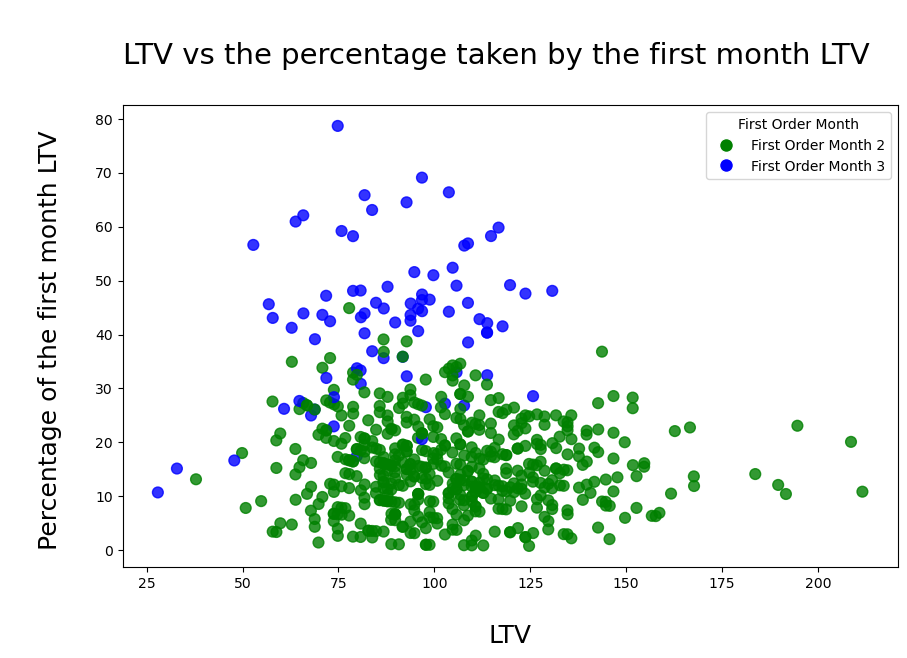

In [91]:
# Define a simple color map for `first_order_mth`
color_map_scat = {2: "green", 3: "blue"}

# Creating the cluster graph
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    df_LTVs["LTV"],
    df_LTVs["fmLTV_LTV_perc"],
    c=df_LTVs["first_order_mth"].map(color_map_scat),  # Map colors
    label="First Order Month",
    s=60,
    alpha=0.8
)

# Adding legend
legend_labels = [plt.Line2D([0], [0], marker="o", color="w", markersize=10, 
                            markerfacecolor=color, label=f"First Order Month {value}")
                 for value, color in color_map_scat.items()]

plt.legend(handles=legend_labels, title="First Order Month", loc="upper right")


# Adding titles and labels
plt.title("\nLTV vs the percentage taken by the first month LTV\n", fontsize=21,
          loc="left"
          )
plt.xlabel("\nLTV", fontsize=18)
plt.ylabel("\nPercentage of the first month LTV \n", fontsize=18)

# Showing the graph
plt.show()

#### Observations:
<a id="obs_1"></a>

I clearly see **2 different patterns** here.  
The first orders in **March have a much less big LTV** but a **higher percentage for that first month LTV**. Quite the **opposite for Feb.**: much bigger LTVs and lower percentages for the fmLTV.  

This means that customers who first ordered in March spent less overall than customers who first ordered in Feb.  
Potential leads to explore:  
- investigate further why March first comers tended to spent more just in March but less overall
- opposite for Feb., why they tended to spend less in Feb. but more overall

This may give insights on how can we make "Marchers" spend to the level of "Febers" and maybe make new 1st Febers spent more than average 1st Marchers.

This is of course a very short analysis as it is now. A proper methodology and preprocessing is needed for serious results. Alternatively, a faster approach is to explore more of the data, which will bring to light more potential leads to consider. 

The **distributions seem to be normal** (gaussian) for both, much narrower for March and much wider for Feb., with a few outliers for both. 

#### Box plots:  
I want to check further details via a box plot for each variable.

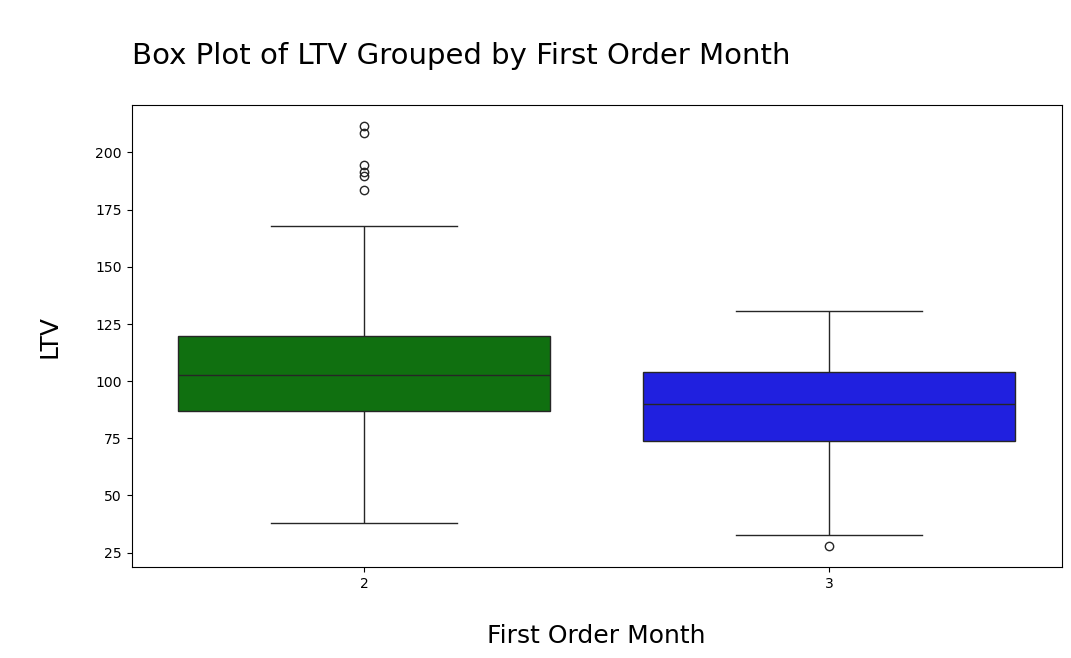

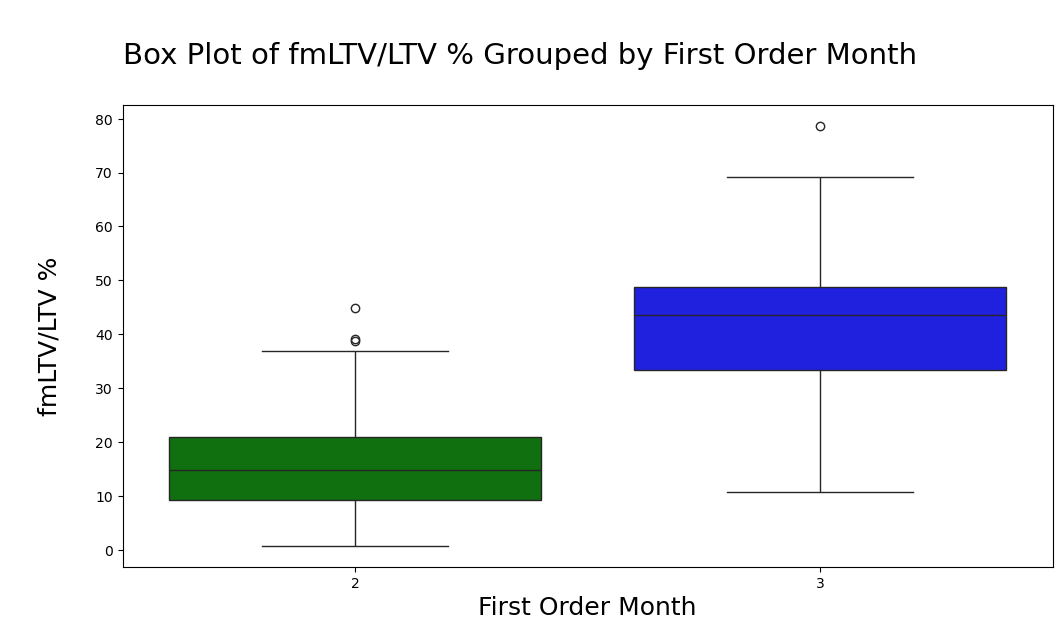

In [102]:
color_map = {2: "green", 3: "blue"}

# Box plot for `LTV` grouped by `first_order_mth`
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_LTVs, x="first_order_mth", y="LTV", hue="first_order_mth", palette=color_map, dodge=False, legend=False)
plt.title("\nBox Plot of LTV Grouped by First Order Month\n", fontsize=21, loc="left")
plt.xlabel("\nFirst Order Month", fontsize=18)
plt.ylabel("\nLTV\n", fontsize=18)
plt.legend([], [], frameon=False)  # Removes legend if not needed
plt.show()

# Box plot for `fmLTV_LTV_perc` grouped by `first_order_mth`
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_LTVs, x="first_order_mth", y="fmLTV_LTV_perc", hue="first_order_mth", palette=color_map, dodge=False, legend=False)
plt.title("\nBox Plot of fmLTV/LTV % Grouped by First Order Month\n", fontsize=21, loc="left")
plt.xlabel("First Order Month", fontsize=18)
plt.ylabel("\nfmLTV/LTV %\n", fontsize=18)
plt.legend([], [], frameon=False)  # Removes legend if not needed
plt.show()


My **observations are confirmed** with the box plots.  
In LTV, the first half of all Feb LTVs is where the 2/3 of March LTVs are. And Feb last quarter surpasses by about 30 points the last quarter of March, which has no high outliers. 

And again, the opposite for first months LTV, but here the differences are much more contrasted. The whole Feb here is barely above the first quarter of all March fmLTV.


---


### CTE & Windows Function:  
<a id="mult-cte"></a>
CTEs are **great to simplify complex queries** by breaking them into smaller, more manageable parts. I am using CTEs and a union clause in the code below to illustrate that further.  
We'll see that while the code is indeed simpler, it is **not necessarily less verbose**. 

In a **second approach** I use a more **advanced technique** to get the same query. This will introduce **window functions** and show how they can make **SQL queries less verbose and more efficient**. 

#### Top DVD by rating: 

Let's say I am requested to find:
- the top DVD (its rental amount) 
- by rating type.  
  
I start by knowing how many ratings there is. The code below shows us 5 ratings and their label.

In [93]:
stmt = select(
    f.c.rating.label("ratings_types")
).distinct()

execute_stmt(stmt, engine)


Total rows selected: 5

Raw SQL query:
SELECT DISTINCT film.rating AS ratings_types 
FROM film

ratings_types
R
PG-13
G
PG
NC-17


#### Basic Select Statement:

I start with the basic select of the rows I need: 

In [94]:
ffid = f.c.film_id
ft = f.c.title
fr = f.c.rating

stmt_topDVD_byRating = (
    # selecting the following columns from the film table...
    select(
        ffid.label("DVD_id"),
        ft.label("title"),
        func.sum(pa).label("dvd_ttal_amnt")
    )
    .join(
        i
    )
    .join(
        r
    ).join(
        p
    )
    .where(
        # ...filtered by this rating alone...
        fr == "NC-17"
    )
    .order_by(
        # ...sorted by total order amount, highest first and...
        desc(func.sum(pa))
    )
).group_by(
    ffid,
    ft
).limit(1)  # ...returning ONLY the highest (top DVD)

execute_stmt(stmt_topDVD_byRating, engine)


Total rows selected: 202
Limit of 1 applied. Rows displayed: 1

Raw SQL query:
SELECT film.film_id AS "DVD_id", film.title AS title, sum(payment.amount) AS dvd_ttal_amnt 
FROM film JOIN inventory ON film.film_id = inventory.film_id JOIN rental ON inventory.inventory_id = rental.inventory_id JOIN payment ON rental.rental_id = payment.rental_id 
WHERE film.rating = %(rating_1)s GROUP BY film.film_id, film.title ORDER BY sum(payment.amount) DESC 
 LIMIT %(param_1)s

DVD_id | title | dvd_ttal_amnt
1000 | Zorro Ark | 199.72


#### Turning it into a CTE:  

Now I am turning it into a CTE by just adding the method .cte() at the very end of the select statement. I then reuse it in the execute.

In [95]:
CTE_stmt_N17 = (
    # selecting the following DVD columns...
    select(
        ffid.label("DVD_id"),
        ft.label("title"),
        func.sum(pa).label("dvd_ttal_amnt")
    )
    .join(
        i
    )
    .join(
        r
    ).join(
        p
    )
    .where(
        # ...filtered by this rating alone...
        fr == "NC-17"
    )
    .order_by(
        # ...sorted by total order amount, highest first and...
        desc(func.sum(pa))
    )
).group_by(
    ffid,
    ft
).limit(1).cte("N-17-cte")

stmt_N17 = select(*CTE_stmt_N17.c)
execute_stmt(stmt_N17, engine)


Total rows selected: 1
Limit of 1 applied. Rows displayed: 1

Raw SQL query:
WITH "N-17-cte" AS 
(SELECT film.film_id AS "DVD_id", film.title AS title, sum(payment.amount) AS dvd_ttal_amnt 
FROM film JOIN inventory ON film.film_id = inventory.film_id JOIN rental ON inventory.inventory_id = rental.inventory_id JOIN payment ON rental.rental_id = payment.rental_id 
WHERE film.rating = %(rating_1)s GROUP BY film.film_id, film.title ORDER BY sum(payment.amount) DESC 
 LIMIT %(param_1)s)
 SELECT "N-17-cte"."DVD_id", "N-17-cte".title, "N-17-cte".dvd_ttal_amnt 
FROM "N-17-cte"

DVD_id | title | dvd_ttal_amnt
1000 | Zorro Ark | 199.72


#### 3 CTEs for 3 Ratings:  
Now we can just copy that CTE code to get 2 more ratings: 
- "R" 
- and "G" for example.  

For that I will just turn the code into a function and then use it to get the two other CTEs. 

In [96]:
def create_rating_CTE(rating: str):
    """_summary_: 
    example: create_rating_CTE("R")

    Args:
        rating (str): the rating for which the top DVD order amount will be returned
    """
    label = f"{rating}-cte"
    rating = str(rating)
    
    # 
    cte = select(
        ffid.label("DVD_id"),
        ft.label("title"),
        func.sum(pa).label("dvd_ttal_amnt")
        ).join(
            i
        ).join(
            r
        ).join(
            p
        ).where(
            fr == rating
        ).order_by(
            desc(func.sum(pa))
        ).group_by(
        ffid,
        ft).limit(1).cte(f"{label}")
    return cte

I can now create and verify my CTEs:

In [97]:
CTE_stmt_R = create_rating_CTE("R")
CTE_stmt_G = create_rating_CTE("G")

stmt_R = select(
    *CTE_stmt_R.c
    )
stmt_G = select(
    *CTE_stmt_G.c
    )

execute_stmt(stmt_R, engine)
execute_stmt(stmt_G, engine)


Total rows selected: 1
Limit of 1 applied. Rows displayed: 1

Raw SQL query:
WITH "R-cte" AS 
(SELECT film.film_id AS "DVD_id", film.title AS title, sum(payment.amount) AS dvd_ttal_amnt 
FROM film JOIN inventory ON film.film_id = inventory.film_id JOIN rental ON inventory.inventory_id = rental.inventory_id JOIN payment ON rental.rental_id = payment.rental_id 
WHERE film.rating = %(rating_1)s GROUP BY film.film_id, film.title ORDER BY sum(payment.amount) DESC 
 LIMIT %(param_1)s)
 SELECT "R-cte"."DVD_id", "R-cte".title, "R-cte".dvd_ttal_amnt 
FROM "R-cte"

DVD_id | title | dvd_ttal_amnt
938 | Velvet Terminator | 152.77

Total rows selected: 1
Limit of 1 applied. Rows displayed: 1

Raw SQL query:
WITH "G-cte" AS 
(SELECT film.film_id AS "DVD_id", film.title AS title, sum(payment.amount) AS dvd_ttal_amnt 
FROM film JOIN inventory ON film.film_id = inventory.film_id JOIN rental ON inventory.inventory_id = rental.inventory_id JOIN payment ON rental.rental_id = payment.rental_id 
WHERE film

#### Union clause:
And use them in a union clause to have a more readable output: 

In [98]:
stmt = union(
    stmt_N17,
    stmt_R,
    stmt_G)

execute_stmt(stmt, engine)


Total rows selected: 3
Limit of 1 applied. Rows displayed: 3

Raw SQL query:
WITH "N-17-cte" AS 
(SELECT film.film_id AS "DVD_id", film.title AS title, sum(payment.amount) AS dvd_ttal_amnt 
FROM film JOIN inventory ON film.film_id = inventory.film_id JOIN rental ON inventory.inventory_id = rental.inventory_id JOIN payment ON rental.rental_id = payment.rental_id 
WHERE film.rating = %(rating_1)s GROUP BY film.film_id, film.title ORDER BY sum(payment.amount) DESC 
 LIMIT %(param_1)s), 
"R-cte" AS 
(SELECT film.film_id AS "DVD_id", film.title AS title, sum(payment.amount) AS dvd_ttal_amnt 
FROM film JOIN inventory ON film.film_id = inventory.film_id JOIN rental ON inventory.inventory_id = rental.inventory_id JOIN payment ON rental.rental_id = payment.rental_id 
WHERE film.rating = %(rating_2)s GROUP BY film.film_id, film.title ORDER BY sum(payment.amount) DESC 
 LIMIT %(param_2)s), 
"G-cte" AS 
(SELECT film.film_id AS "DVD_id", film.title AS title, sum(payment.amount) AS dvd_ttal_amnt 
F

#### Advanced Approach: row_number() Window Function  
<a id="cte-winfunc"></a>
With the row_number() function I can: 
1. **partition the result** by the values of a columns (.i.e.: the different ratings)
2. and then **create a separate incrementing index** that references each value of each partition

**Point 1.** here is essentially what I did by creating each of the three CTE.   
**Point 2** is helping me sorting out or even selecting a specific column, here it is the total order of each DVD or the top 1st DVD by total order amount (index 1). 

To show this I am **additionally selecting**: 
- the film rating (the partitions)
- the row_number() function (assigned to a variable `row_num`, labelled rating_index)

And I am **sorting it by film rating** so the output will give all **results for one rating first**, and its **corresponding row number** (the rating_index column). 

The output from the code below does not show enough rows (it'd take over 168 rows to show it) however it is clear the rating_index column numbers are incremented starting at 1, the top DVD with the biggest amount of orders for that rating. 

In [99]:
# assigning the row_number function:
row_num = func.row_number().over(
    # partitioning film ratings
    partition_by=fr,
    # sorting them by order amount, biggest first
    order_by=func.sum(pa).desc()
)

stmt = select(
    ffid.label("DVD_id"),
    ft.label("title"),
    fr,
    func.sum(pa).label("dvd_ttal_amnt"),
    # selecting the var of the row_number() function
    row_num.label("rating_index")
    ).join(
        i
    ).join(
        r
    ).join(
        p
    # no need of the where clause anymore
    ).order_by(
        fr
    ).group_by(
    ffid,
    ft
    )#.limit(10)
    
execute_stmt(stmt, engine, 10)


Total rows selected: 958

Raw SQL query:
SELECT film.film_id AS "DVD_id", film.title AS title, film.rating, sum(payment.amount) AS dvd_ttal_amnt, row_number() OVER (PARTITION BY film.rating ORDER BY sum(payment.amount) DESC) AS rating_index 
FROM film JOIN inventory ON film.film_id = inventory.film_id JOIN rental ON inventory.inventory_id = rental.inventory_id JOIN payment ON rental.rental_id = payment.rental_id GROUP BY film.film_id, film.title ORDER BY film.rating

DVD_id | title | rating | dvd_ttal_amnt | rating_index
764 | Saturday Lambs | G | 190.74 | 1
897 | Torque Bound | G | 169.76 | 2
239 | Dogma Family | G | 168.72 | 3
127 | Cat Coneheads | G | 159.73 | 4
778 | Secrets Paradise | G | 139.82 | 5
350 | Garden Island | G | 134.82 | 6
409 | Heartbreakers Bright | G | 132.80 | 7
271 | Easy Gladiator | G | 132.80 | 8
575 | Midsummer Groundhog | G | 129.82 | 9
61 | Beauty Grease | G | 125.79 | 10


#### Top DVD by rating: 

I can now make a CTE of that whole statement and use it to get:
- the top movie 
- by total order 
- for each rating

In a neat output:

In [100]:
cte = select(
    ffid.label("DVD_id"),
    ft.label("title"),
    fr,
    func.sum(pa).label("dvd_ttal_amnt"),
    # selecting the var of the row_number() function
    row_num.label("rating_index")
    ).join(
        i
    ).join(
        r
    ).join(
        p
    # no need of the where clause anymore
    ).order_by(
        fr
    ).group_by(
    ffid,
    ft
    ).cte()

stmt_topDVD_perRating = select(
    # all dvd rating by order amount, biggest first...
    *cte.c).where(
        # and return only the first (the top DVD)
        cte.c.rating_index == 1
    )

execute_stmt(stmt_topDVD_perRating, engine)


Total rows selected: 5

Raw SQL query:
WITH anon_1 AS 
(SELECT film.film_id AS "DVD_id", film.title AS title, film.rating AS rating, sum(payment.amount) AS dvd_ttal_amnt, row_number() OVER (PARTITION BY film.rating ORDER BY sum(payment.amount) DESC) AS rating_index 
FROM film JOIN inventory ON film.film_id = inventory.film_id JOIN rental ON inventory.inventory_id = rental.inventory_id JOIN payment ON rental.rental_id = payment.rental_id GROUP BY film.film_id, film.title ORDER BY film.rating)
 SELECT anon_1."DVD_id", anon_1.title, anon_1.rating, anon_1.dvd_ttal_amnt, anon_1.rating_index 
FROM anon_1 
WHERE anon_1.rating_index = %(rating_index_1)s

DVD_id | title | rating | dvd_ttal_amnt | rating_index
764 | Saturday Lambs | G | 190.74 | 1
879 | Telegraph Voyage | PG | 215.75 | 1
460 | Innocent Usual | PG-13 | 191.74 | 1
938 | Velvet Terminator | R | 152.77 | 1
1000 | Zorro Ark | NC-17 | 199.72 | 1



---
